# Data Analysis for the model performance on actual jobs <a class="tocSkip">

**Authors:** Pedro Balage

**Keywords:** Data Analisys; Quality Estimation; Machine Translation

**Last Update:** 22/12/2020

---
## SUMMARY <a class="tocSkip">

### Goals <a class="tocSkip">

- Explore the Translation Validation data available on DC Platform using actual unbalanced jobs
- Understand the distribution between good and bad translations
- Evaluate our Quality Estimation models against benchmarks
- Perform a metric analysis and conclusions

### Main Outcomes <a class="tocSkip">

* Actual jobs with a strong unbalanced data represent a challenge to our quality estimation models.
* For most of the past job batches, we observe a skewed distribution between 'good translation' (ones with translation accuracy) and 'bad translations' (ones without translation accuracy). 
* The 'bad translations', in the analysed jobs batches, represent the class with less examples. This class has on average 7.00% (+/- 6.44%) of the entire set of translation pairs (14x less than the other class).
* In this data, we also observed that our model is able to correlate the lower translation quality scores with the 'bad translations' class and the higher translation quality scores with the 'good translations' class.
* When benchmarked against the commercial solution ModelFront, our model is able to offer a better performance measured by the Area Under the Curve (AUC) and the recall on the "bad translations".
* In addition, we observe that our model when used for classification purpose is very sensitie to the threshold that split into 'bad translations' (scores lower than the threshold) to 'good translations' (score bigger than the trehshold). 
* For this threshold decision, we need to respect a trade-off between precision and recall, i.e, to ajust the threshold to recognize more 'bad translations' also increases the number of false positives ('good translations' categorized as 'bad').
* We show, in this notebook, the optimal thresholds to improve the recall over 'bad translations' and how different tresholds would behaviour in different job batches.
* We suggest the use of this information to guide translation quality tasks.

In [1]:
# imports
import os
import warnings
import itertools
import collections
from pathlib import Path

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib as mpl
from matplotlib import style
import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.transforms import Bbox

import seaborn as sns

from tqdm import tqdm

# ML metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    mean_squared_error,
    precision_recall_curve,
    PrecisionRecallDisplay,
)

from src.models.crosslingual_cosine_similarity import CrosslingualCosineSimilarity

In [2]:
# notebook formaters
class _IntArrayFormatter(pd.io.formats.format.GenericArrayFormatter):
    def _format_strings(self) -> list:
        formatter = self.formatter or (lambda x: " {:,}".format(x))
        fmt_values = [formatter(x) for x in self.values]
        return fmt_values


# Two decimal places to display float numbers
pd.options.display.float_format = "{:,.2f}".format

pd.io.formats.format.IntArrayFormatter = _IntArrayFormatter
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

# surpress matplot warnings
warnings.filterwarnings("ignore")
matplotlib_axes_logger.setLevel("ERROR")

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

# function to support saving plots to disk
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels()
    #    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)


# load black extension to format all cells
#%load_ext nb_black
%load_ext lab_black

## Dataset

The dataset studied in this research is a collection of manually picked translation validation jobs. The general criteria to select the jobs were:
- Language pairs;
- Diversity: 
   - we collected jobs with a broad range of number of executions,
   - with 1, 2 or 3 answer options.

The jobs can be described with the following table:

<br>

| Job id | Language Pair | Hits | Total   | Intelligible | Accuracy | Fluency |
|-------:|--------------:|-----:|--------:|-------------:|---------:|--------:|
|    6195|English-Italian|  2276|     2874|          2859|      96.3|     95.1|
|    5478|English-Italian|  1000|     1000|           971|      94.4|     92.7|
|    6194|English-Russian|   920|      986|           947|      88.2|     69.1|
|    5510|English-Russian|  1000|     3000|          2937|      92.7|     82.8|
|    5477| English-Arabic|  1000|     1000|           966|      95.9|     84.6|
|    6198| English-Arabic|  2289|     2864|          2752|      90.0|     74.6|
|    5479| English-Japanese|  1000|     1000|          908|      72.6|     39.4|
|    5526| English-Japanese|  1000|     2000|          1934|      98.6|     93.1|
|    6197| English-Japanese|  2404|     3010|          3004|      99.8|     97.5|
|    5499|English-Korean|   1000|      3000|           2900|      97.1|     90.0|
|    6196|English-Korean|   2409|      3002|           2814|      90.3|     77.4|
|    6744|English-Korean|   1000|      3000|           2986|      86.1|     82.5|
|    6222| Korean-English|   2944|      3137|           2941|      88.5|     79.8|
|    6742| Korean-English|   1000|      3000|           2982|      94.3|     89.3|
|    5215| Portuguese-Chinese|  1000|     1000|          959|      84.5|     70.2|
|    5211| Russian-Chinese|  1000|     1000|          1000|      93.6|     82.2|
|    5214| Russian-Chinese|  1000|     1000|          985|      82.2|     63.0|
|    6709| English-French|  1000|     3000|          2981|      97.4|     93.9|
|    6743| Korean-Chinese|  1000|     3000|          2994|      95.7|     91.2|
|    6763| Japanese-English|  1000|     2011|          1992|      91.2|     88.8|
|    6778| Korean-Japanese|  1000|     3000|          2984|      97.3|     91.2|
|    6708| English-German|  1000|     3000|          2982|      92.9|     89.3|
|    6741| Japanese-Chinese|  1000|     3000|          2999|      95.4|     93.3|

In the job hits, grouped by language pair, we have 3 possible answers.

1) source-intelligible: **Is the source intelligible?** (**True** or **False**)

2) accuracy: **Is the meaning of the source conveyed?** (**True** or **False**)

3) fluency: **Are translations fluent and sound natural in the target language?** (**True** or **False**)

In this work, we adopt **accuracy** as the mesure of the quality for a given translation (good and bad translations).

We noticed a remarkable imbalance between **good translations** (True) and **bad translations** (False) classes. For this evaluation, we generated a **balanced testing dataset** by selecting a sample of the examples and using a downsampling strategy for balancing. 

The dataset used in this evaluation was produced by the `make data` command within the [repository](https://definedcrowd.visualstudio.com/DefaultCollection/DefinedCrowd/_git/NLP.MachineTranslation.QualityEstimationAPI), or by directly executing the make_dataset script

`$ python -m src.data.make_dataset`

**Paths**

In [3]:
# project directory
project_dir = Path(".").resolve().parent

# 'Testing' dataset created by `make data`
DATASET_PATH = project_dir / "data" / "processed" / "validation" / "dataset.csv"

**Import Dataset**

In [4]:
# reading the data
df = pd.read_csv(DATASET_PATH)
df.sample(10)

,language_pair,source,target,accuracy,jobid,agreement
"28,814",ru-en,[1] Вознаграждение взимается в белорусских рублях по курсу Национального банка Республики Беларусь на день приема на инкассо.,[1] The fee is charged in Belarusian rubles at the exchange rate of the National Bank of the Republic of Belarus on the day of collection.,True,"4,934",True
"19,933",jp-zh,へぇー、 カフェ,嘿~，咖啡厅,True,"6,741",True
"10,867",en-zh,Think Autonomous | Oracle Autonomous Database Cloud,考虑自治/ Oracle自治数据库云,True,"4,786",False
"23,996",zh-it,你都忘记在美国了,Hai dimenticato di essere in America,True,"5,134",False
"11,356",en-zh,"Report Ad BACK TO EDMODO Quizzes you may like 15 Qs Bones Bones Bones 22.3k plays 18 Qs Muscular System 25.0k plays 20 Qs Skeletal, Muscular, Integumentary 7.6k plays 17 Qs Skeletal System 3.1k plays 19 Qs Skeletal/Muscular Systems 3.7k plays Science - 5th 10 Qs Muscles of the Body 7.2k plays 15 Qs Joints 1.1k plays Quiz not found!",报告 广告 返回至EDMODO 您可能喜欢的测验 15问题 骨骼 骨骼 骨骼 22.3k播放 18问题 肌肉系统 25.0k播放 20问题 骨骼，肌肉，外皮 7.6k播放 17问题 骨骼系统 3.1k播放 19问题 骨骼/肌肉系统3.7k播放 科学-第五名 10 问题 身体的肌肉7.2k播放 15问题 关节1.1k播放 找不到测验！,True,"4,786",False
"5,574",en-de,What I really miss is the good old New Orleans food,"Was ich wirklich vermisse, ist das Essen aus New Orleans",True,"6,708",True
"10,704",en-ko,He is very romantic,그는 진짜 로맨틱하지,True,"6,744",True
"9,551",en-ko,Luckily I remember the umbrella,다행히 저는 그 우산을 기억합니다,True,"5,499",True
"27,282",ru-en,Перевести контакт из подписчиков в друзья очень просто: зайти на страницу контакта и нажать «Добавить в друзья».,The transfer of contact from subscribers to friends is very simple: just go to the contact page and click Add to Friends.,True,"4,934",True
"8,274",ru-zh,"Падая, она откинула поводок в руке и он как раз металическим карабином заехал Ивану Степановичу в глаз.",当她摔倒时，，她把手中的皮带扔了回去，他就这样拿着一把金属卡宾枪跑到了伊万-斯捷潘诺维奇的眼前。,True,"5,211",False


In [5]:
# checks for data consistency
assert "language_pair" in df
assert "accuracy" in df
assert df["accuracy"].dtype == bool

**Data Analysis**

Let's see the number of translations pairs per language distribution and accuracy

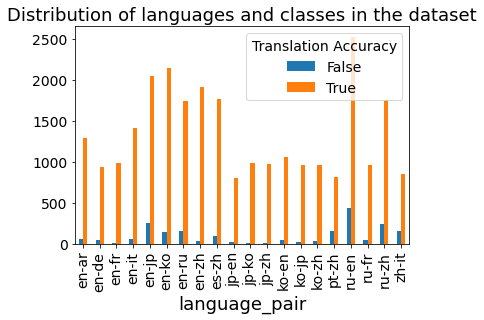

In [6]:
# plot the distribution of languages and classes.
fig = pd.crosstab(df["language_pair"], df["accuracy"]).plot.bar()
_ = plt.title("Distribution of languages and classes in the dataset")
_ = plt.legend(["False", "True"], title="Translation Accuracy")

How many jobs ids and languages do I have?

In [7]:
df_group = df.groupby(
    ["language_pair", "jobid", "agreement"],
)
a = pd.DataFrame(df_group.accuracy.value_counts()).rename(columns={"accuracy": "count"})
b = pd.DataFrame(df_group.accuracy.value_counts(normalize=True)).rename(
    columns={"accuracy": "frequency"}
)
df_group = pd.concat([a, b], axis=1)
df_group

count  frequency
language_pair jobid agreement accuracy                  
en-ar         5,477 False     True        926       0.96
                              False        40       0.04
              6,198 True      True        365       0.97
                              False        12       0.03
en-de         6,708 True      True        932       0.95
                              False        49       0.05
en-fr         6,709 True      True        979       0.99
                              False         5       0.01
en-it         5,478 False     True        917       0.94
                              False        54       0.06
              6,195 True      True        493       0.99
                              False         7       0.01
en-jp         5,479 False     True        659       0.73
                              False       249       0.27
              5,526 True      True        834       1.00
                              False         2       0.00
              6,197 True      True        549       1.00
en-ko         5,499 True      True        937       0.98
                              False        19       0.02
              6,196 True      True        345       0.95
                              False        18       0.05
              6,744 True      True        862       0.89
                              False       111       0.11
en-ru         5,510 True      True        904       0.95
                              False        46       0.05
              6,194 False     True        835       0.88
                              False       112       0.12
en-zh         4,786 False     True      1,898       0.98
                              False        29       0.02
              4,906 False     True         17       0.89
                              False         2       0.11
es-zh         5,115 False     True        924       0.97
                              False        26       0.03
              5,116 False     True        835       0.92
                              False        72       0.08
jp-en         6,763 True      True        795       0.97
                              False        24       0.03
jp-ko         6,740 True      True        988       1.00
                              False         3       0.00
jp-zh         6,741 True      True        976       0.99
                              False        14       0.01
ko-en         6,222 True      True        125       0.88
                              False        17       0.12
              6,742 True      True        937       0.97
                              False        28       0.03
ko-jp         6,778 True      True        954       0.98
                              False        16       0.02
ko-zh         6,743 True      True        953       0.97
                              False        30       0.03
pt-zh         5,215 False     True        810       0.84
                              False       149       0.16
ru-en         4,934 True      True      1,683       0.85
                              False       305       0.15
              5,113 False     True        841       0.87
                              False       124       0.13
ru-fr         5,149 False     True        953       0.95
                              False        47       0.05
ru-zh         5,211 False     True        936       0.94
                              False        64       0.06
              5,214 False     True        810       0.82
                              False       175       0.18
zh-it         5,134 False     True        850       0.85
                              False       149       0.15

In [8]:
# Let's take some statistics on that
df_group = df_group.reset_index()
print(
    f"Average frequency for 'good translations' in the job batches: {df_group[df_group.accuracy == True].frequency.mean()*100:.2f}% (+/- {df_group[df_group.accuracy == True].frequency.std()*100:.2f}%)"
)
print(
    f"Average frequency for 'bad translations' in the job batches:   {df_group[df_group.accuracy == False].frequency.mean()*100:.2f}% (+/- {df_group[df_group.accuracy == False].frequency.std()*100:.2f}%)"
)

Average frequency for 'good translations' in the job batches: 93.22% (+/- 6.45%)
Average frequency for 'bad translations' in the job batches:   7.00% (+/- 6.44%)


In [9]:
# Let's check again the number of translation pairs per language
print("Number of Translation pairs per language")
df.language_pair.value_counts()

Number of Translation pairs per language


ru-en    2,953
en-jp    2,293
en-ko    2,292
ru-zh    1,985
en-zh    1,946
en-ru    1,897
es-zh    1,857
en-it    1,471
en-ar    1,343
ko-en    1,107
ru-fr    1,000
zh-it      999
jp-ko      991
jp-zh      990
en-fr      984
ko-zh      983
en-de      981
ko-jp      970
pt-zh      959
jp-en      819
Name: language_pair, dtype: int64

## Selecting a subset of examples for this analysis

The goal is to select some of the language paris for a deeper analysis. Our choice is:

* 'jp-zh': because 'zh-jp' is one of the languages for the Apple Pilot running on Dec/2020
* 'en-jp': because it is one of the languages for the Apple Pilot running on Dec/2020
* 'en-de': a language pair in the same language family (Proto-Germanic)
* 'ru-en': a language pair between two different language families

In [10]:
# let's select few language pairs for our analysis
LANGUAGE_PAIRS = ["en-jp", "jp-zh", "en-de", "ru-en"]

In [11]:
df_lang = pd.DataFrame()
for language_pair in LANGUAGE_PAIRS:
    df_lang = pd.concat([df_lang, df[df.language_pair == language_pair]])
df = df_lang

In [12]:
# Let's check again the job ids that are part in this selection
df_group = df.groupby(
    ["language_pair", "jobid", "agreement"],
)
a = pd.DataFrame(df_group.accuracy.value_counts()).rename(columns={"accuracy": "count"})
b = pd.DataFrame(df_group.accuracy.value_counts(normalize=True)).rename(
    columns={"accuracy": "frequency"}
)
df_group = pd.concat([a, b], axis=1)
df_group

count  frequency
language_pair jobid agreement accuracy                  
en-de         6,708 True      True        932       0.95
                              False        49       0.05
en-jp         5,479 False     True        659       0.73
                              False       249       0.27
              5,526 True      True        834       1.00
                              False         2       0.00
              6,197 True      True        549       1.00
jp-zh         6,741 True      True        976       0.99
                              False        14       0.01
ru-en         4,934 True      True      1,683       0.85
                              False       305       0.15
              5,113 False     True        841       0.87
                              False       124       0.13

What is the language distribution and how balanced it is?

Let's look into the numbers of this distrubution

In [13]:
# How unbalanced this sample is?
print("Number of examples per Translation Accuracy")
df.accuracy.value_counts()

Number of examples per Translation Accuracy


True     6,474
False      743
Name: accuracy, dtype: int64

In [14]:
# How many examples do I have per language?
print("Number of examples per Language Pair")
df.language_pair.value_counts()

Number of examples per Language Pair


ru-en    2,953
en-jp    2,293
jp-zh      990
en-de      981
Name: language_pair, dtype: int64

In [15]:
# Do I have duplicated items in the selection?
df[df.duplicated(subset=["source"], keep=False)].sort_values("source").head()

,language_pair,source,target,accuracy,jobid,agreement
"27,081",ru-en,(Нет голосов),(0 votes),True,"4,934",True
"26,893",ru-en,(Нет голосов),(0 votes),True,"4,934",True
"25,940",ru-en,(Нет голосов),(No votes),True,"5,113",False
"28,301",ru-en,"(Шум, много реплик.)","(Noise, a lot of lines.)",True,"4,934",True
"27,500",ru-en,"(Шум, много реплик.)","(Noise, a lot of lines.)",True,"4,934",True


---
**Analysis**

* The dataset with all validation jobs has 20 language pairs and 32 jobs in total.
* The average frequency for 'good translations' in the job batches is 93.22% (+/- 6.45%) while the 'bad translations' are 7.00% (+/- 6.44%)
* All translation batches (jobs) presented this unbalanced distribution for the 'good translation' class (accuracy=True).
* For our analysis, we selected four language pairs: "en-jp", "jp-zh", "en-de", "ru-en".
* The language pairs selected for the analysis will be used to determine the characteristics of the different job batches in those languages.
* Some duplicated items were verified in the selection, but they are not a problem for the validity of this analysis..
---

## Quality Estimation Prediction

**Baseline Model**

The first model we will use to estimate the quality of the sample is the 'baseline' cross-lingual cosine similarity.

In [36]:
df["baseline"] = None

# Load the model
model = CrosslingualCosineSimilarity("distiluse-base-multilingual-cased-v2")

In [37]:
# process all rows
iter_df = df[df.baseline.isna()]
for i, row in tqdm(iter_df.iterrows(), total=len(iter_df)):
    df.loc[row.name, "baseline"] = model.predict(row.source, row.target)

100%|██████████| 7217/7217 [06:41<00:00, 18.00it/s]


In [38]:
# Do I have any row not processed?
df[df.baseline.isna()]

,language_pair,source,target,accuracy,jobid,agreement,baseline,modelfront


**ModelFront**

ModelFront (https://modelfront.com/) is a technology company that offers scalable solutions for quality estimation. The ModelFront model gives us a translation risk prediction score and is based on deep learning techniques.

We use the predictions from the ModelFront API as our benchmark.

In [35]:
df["modelfront"] = None

In [39]:
import requests
import json
from src.models import modelfront

# A registered account account is necessary to provide this token API.
# A free account give you 1M tokens
# https://console.modelfront.com/#/api
MODELFRONT_TOKEN = "14cd879ef8c1d0156230e761e67c3a7ca658e461747afa6abe8724bf0f5c31fd"

iter_df = df[df.modelfront.isna()]
for i, row in tqdm(iter_df.iterrows(), total=len(iter_df)):

    language = row["language_pair"].split("-")

    # Japanese prefix setting
    language[0] = "ja" if language[0] == "jp" else language[0]
    language[1] = "ja" if language[1] == "jp" else language[1]

    # Data format
    data = {"rows": [{"original": row["source"], "translation": row["target"]}]}
    data = json.dumps(data)

    try:
        # API Request
        r = requests.post(
            "https://api.modelfront.com/v1/predict?sl="
            + language[0]
            + "&tl="
            + language[1]
            + "&token="
            + MODELFRONT_TOKEN,
            data=data.encode("utf-8"),
        )
        if r.status_code == 402:
            raise Exception(
                "API limit achieved. Payment necessary to process further items."
            )
        res = json.loads(r.text)

        # Receives the risk prediction
        score = res["rows"][0]["risk"]

        df.loc[row.name, "modelfront"] = 1 - score

    except Exception as e:
        print(row.name, str(e))

100%|██████████| 1005/1005 [12:51<00:00,  1.30it/s]


In [41]:
# How many tanslation pairs were not processed?
df[df.modelfront.isna()]

,language_pair,source,target,accuracy,jobid,agreement,baseline,modelfront


In [16]:
# Save the pre-processed file
DATASET_PATH = (
    project_dir
    / "data"
    / "processed"
    / "validation"
    / "dataset_selection_processed.csv"
)
# df.to_csv(DATASET_PATH, index=False)

# Alternativelly, load the data frame from the previous processed file
df = pd.read_csv(DATASET_PATH)

**Data Structure**

We converted the 'column' based data structured to 'row' data structure for easy analysis

In [17]:
# convert the 'model columns' to different rows in my dataframe
data = []
for i, row in df.iterrows():
    for model in ["baseline", "custom", "modelfront"]:
        if model in df:
            data.append(
                {
                    "source": row["source"],
                    "target": row["target"],
                    "language_pair": row["language_pair"],
                    "jobid": row["jobid"],
                    "agreement": row["agreement"],
                    "accuracy": row["accuracy"],
                    "model": model,
                    "score": row[model],
                }
            )
df = pd.DataFrame(data)

# General check on the data
df.head(10)

,source,target,language_pair,jobid,agreement,accuracy,model,score
0,All lined up eat me in the warehouse,倉庫内ですべての準備が整いました,en-jp,"5,526",True,False,baseline,0.62
1,All lined up eat me in the warehouse,倉庫内ですべての準備が整いました,en-jp,"5,526",True,False,modelfront,0.96
2,I am at the airport at the moment I am picking somebody up in the next 10 minutes if I don't call you back I am driving back the customer to Epping,私は今空港です。あと10分で人を迎えるのでもし電話を私が返さなかったら、お客様をエッピングに車で送っているところです,en-jp,"5,526",True,False,baseline,0.83
3,I am at the airport at the moment I am picking somebody up in the next 10 minutes if I don't call you back I am driving back the customer to Epping,私は今空港です。あと10分で人を迎えるのでもし電話を私が返さなかったら、お客様をエッピングに車で送っているところです,en-jp,"5,526",True,False,modelfront,1.00
4,Don't eat anything from midnight and only have sips of water after 6 AM,真夜中は何も食べず、午前6時以降は水を少しだけ飲んでき,en-jp,"5,526",True,True,baseline,0.76
5,Don't eat anything from midnight and only have sips of water after 6 AM,真夜中は何も食べず、午前6時以降は水を少しだけ飲んでき,en-jp,"5,526",True,True,modelfront,1.00
6,Follow the orange guy,オレンジの男をフォローしてください,en-jp,"5,526",True,True,baseline,0.76
7,Follow the orange guy,オレンジの男をフォローしてください,en-jp,"5,526",True,True,modelfront,0.99
8,What's the Greek street cleaner,ギリシャの道路掃除は何ですか,en-jp,"5,526",True,True,baseline,0.87
9,What's the Greek street cleaner,ギリシャの道路掃除は何ですか,en-jp,"5,526",True,True,modelfront,0.99


## Data Analysis

Which density distribution do we have on the predicted scores per job batch?

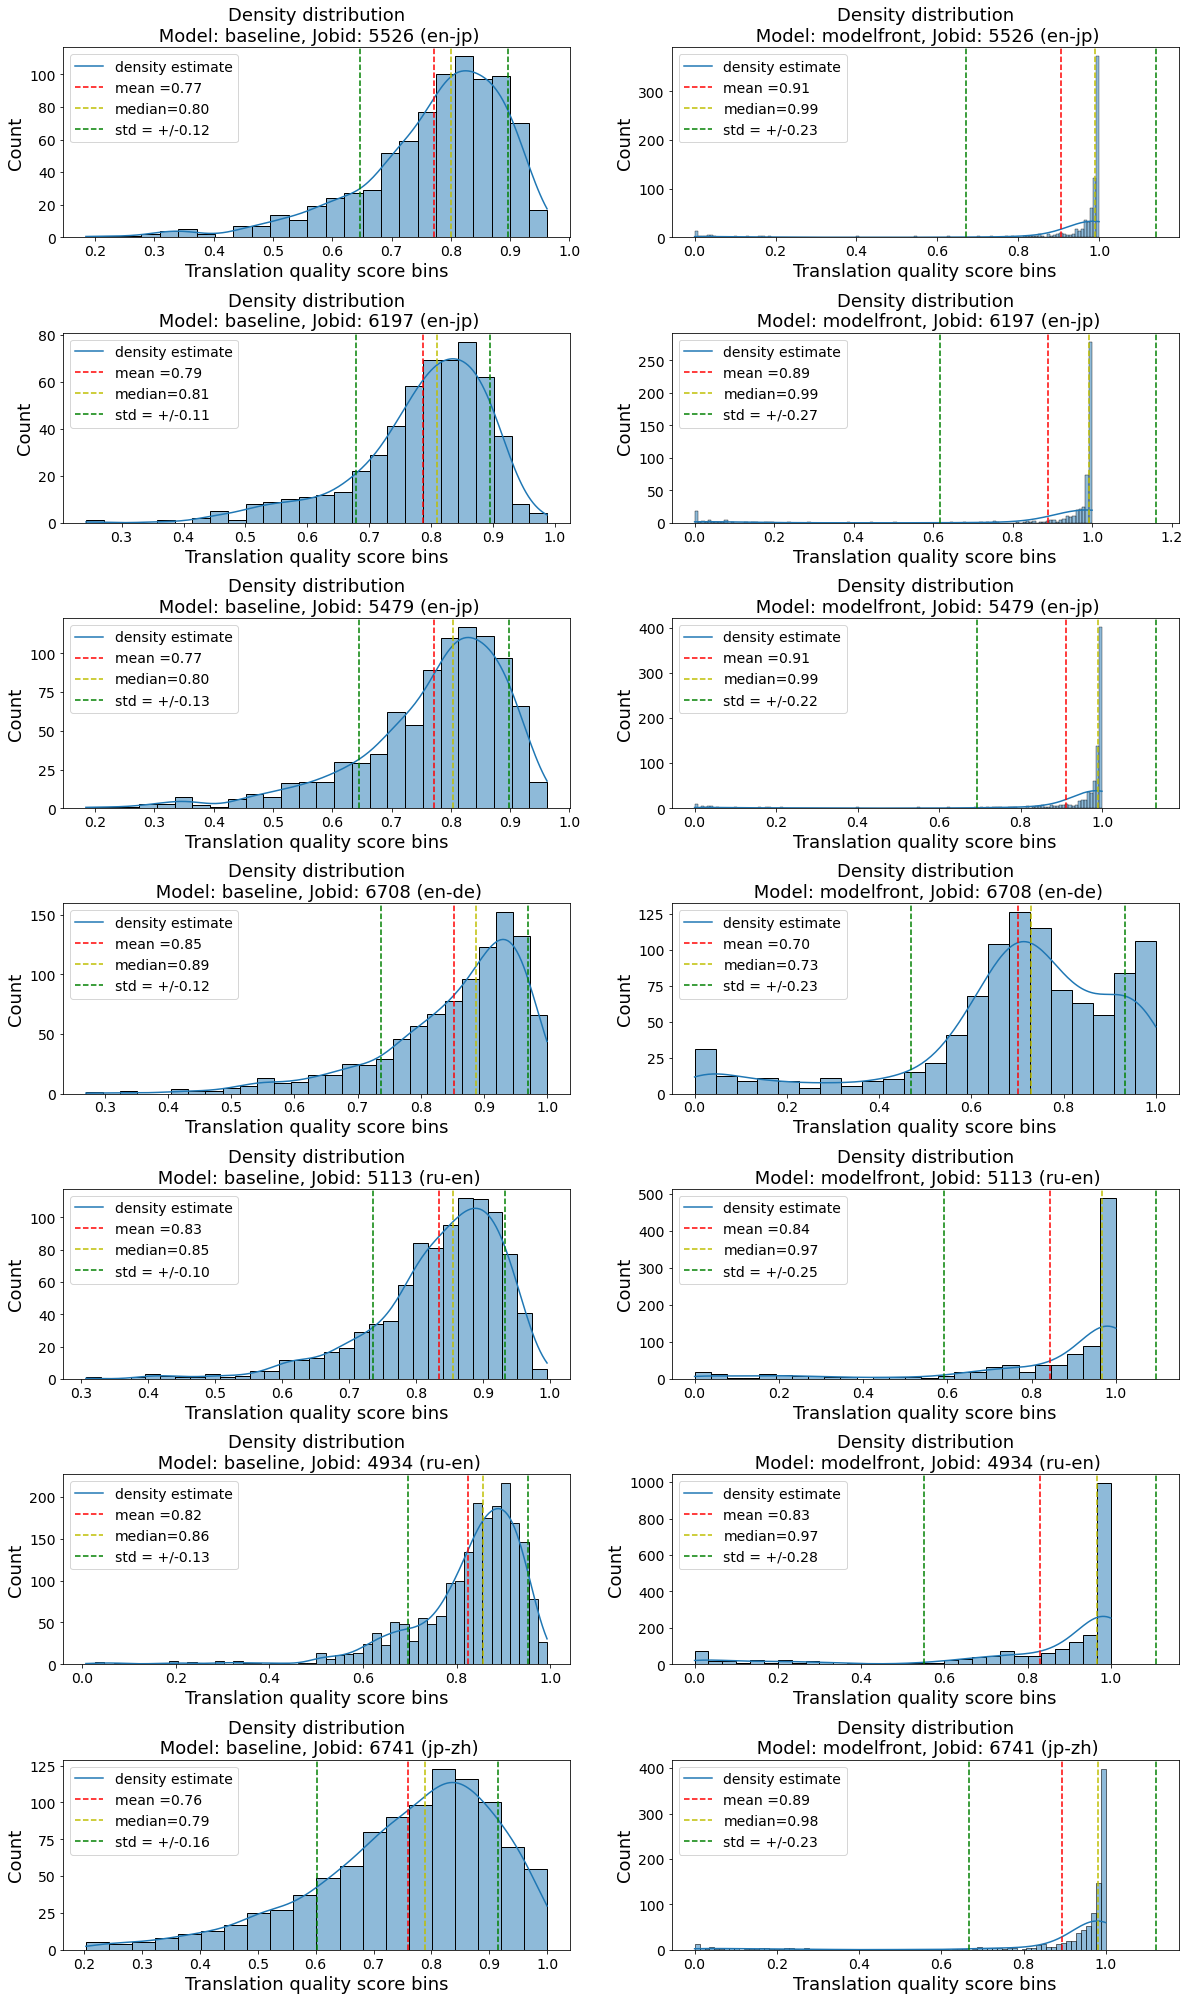

In [28]:
# Configure the number of subplots required to plot the density distribution of scores for each model and jobid
fig, axes = plt.subplots(
    ncols=len(df.model.unique()), nrows=len(df.jobid.unique()), figsize=(20, 35)
)
fig.subplots_adjust(hspace=0.5)

# plot each one of the density functions
for i, model in enumerate(df.model.unique()):
    for j, jobid in enumerate(df.jobid.unique()):
        # only one model hack
        # ax = axes[j]
        ax = axes[j][i]
        language_pair = df[(df.model == model) & (df.jobid == jobid)][
            "language_pair"
        ].values[0]
        sns.histplot(
            x="score",
            data=df[(df.model == model) & (df.jobid == jobid)],
            ax=ax,
            kde=True,
        )
        ax.set_title(
            f"Density distribution\n Model: {model}, Jobid: {jobid} ({language_pair})"
        )
        mean = df[(df.model == model) & (df.jobid == jobid)].score.mean()
        std = df[(df.model == model) & (df.jobid == jobid)].score.std()
        median = df[(df.model == model) & (df.jobid == jobid)].score.median()

        ax.set_xlabel("Translation quality score bins")
        ax.set_ylabel("Count")
        ax.axvline(mean, color="r", linestyle="--")
        ax.axvline(median, color="y", linestyle="--")
        ax.axvline(mean + std, color="g", linestyle="--")
        ax.axvline(mean - std, color="g", linestyle="--")
        ax.legend(
            [
                "density estimate",
                f"mean ={mean:.2f}",
                f"median={median:.2f}",
                f"std = +/-{std:.2f}",
            ]
        )

        # Save just the portion _inside_ the second axis's boundaries
        # extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
        # fig.savefig(f"plots/distribution_{model}_{jobid}.png", bbox_inches=extent)

---
**Analysis:**

* The 'baseline' density distribution has a bell-shaped curve.
* For the 'baseline' results, the mean is around 0.75 to 0.85 with the standard deviation ranging from 0.1 to 0.16.
* ModelFront distribution has a peak close to 1. The exception was the 'en-de' model with a bell-shaped distribution.
* ModelFront resuts with the exception of the 'en-de' model has a mean around 0.83 to 0.91 and a standard deviation ranging from 0.22 to 0.28.
* ModelFront results for the language pair 'en-de' had an average of 0.7 and a standard deviation of 0.23.
---

**Evaluation - Our models x Benchmark**

For the following analysis, we are going to exclude the jobid 6197 ('en-jp') as it only contain 'good translations' and many of our analysis require counting the % of 'bad translations'.

In [29]:
# removing the jobid which only contains 'good tanslations'
df = df[df.jobid != 6197]

To compare different models, we plot the ROC curve and measure the area under the curve (AUC).

An [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

* True Positive Rate
* False Positive Rate

True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:
* TPR = TP / TP + FN

False Positive Rate (FPR) is defined as follows:
* FPR = FP / FP + TN

With the ROC curve, we can measure the area under the curve (AUC). AUC represents the probability that a random positive example (bad translation) is positioned to the right of a random negative (good translation) example. AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

This section shows the AUC - ROC curve calculations (TPR, FPR, Thresholds) for our models.

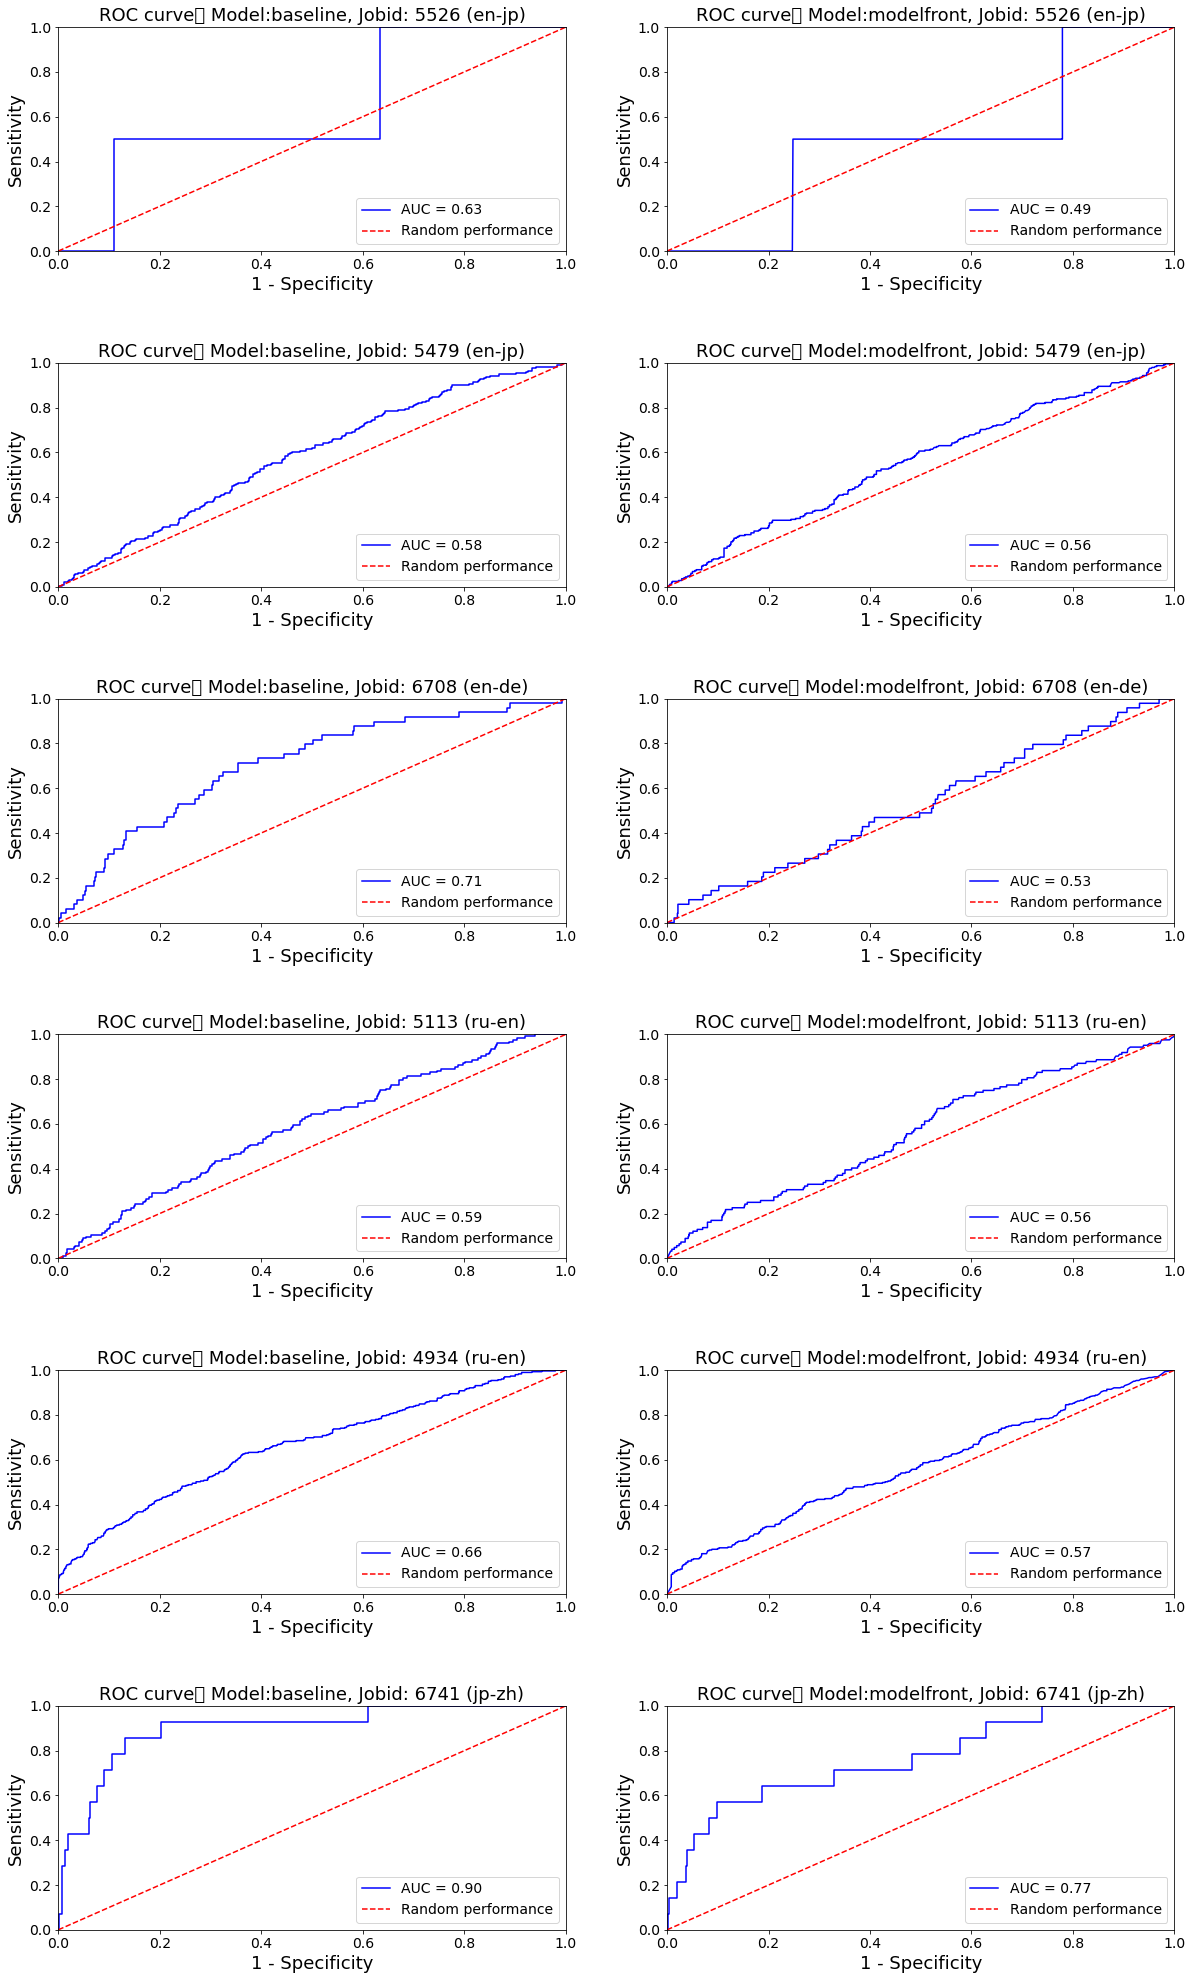

In [30]:
# Invert the labels and scores to put the 'rare' classe (accuracy=False) as positive
df["accuracy"] = df.accuracy.apply(lambda accuracy: not accuracy)
df["score"] = df.score.apply(lambda score: 1 - score)

# Plot the density distribution of scores
fig, axes = plt.subplots(
    ncols=len(df.model.unique()), nrows=len(df.jobid.unique()), figsize=(20, 35)
)
fig.subplots_adjust(hspace=0.5)

# plot each one of the density functions
for i, model in enumerate(df.model.unique()):
    for j, jobid in enumerate(df.jobid.unique()):
        # only one model hack
        # ax = axes[j]
        ax = axes[j][i]

        scores = df[(df.model == model) & (df.jobid == jobid)]["score"]
        y = np.array(
            [
                1 if label == True else 0
                for label in df[(df.model == model) & (df.jobid == jobid)]["accuracy"]
            ]
        )
        language_pair = df[(df.model == model) & (df.jobid == jobid)][
            "language_pair"
        ].values[0]

        fpr, tpr, thresholds = roc_curve(y, scores, pos_label=1)
        auc_score = auc(fpr, tpr)

        ax.plot(fpr, tpr, "b", label=f"AUC = {auc_score:.2f}")
        ax.set_title(f"ROC curve\b Model:{model}, Jobid: {jobid} ({language_pair})")
        ax.plot([0, 1], [0, 1], "r--", label="Random performance")
        ax.legend(loc="lower right")
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_ylabel("Sensitivity")
        ax.set_xlabel("1 - Specificity")

        # Save just the portion _inside_ the second axis's boundaries
        extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(f"plots/roc_{model}_{jobid}.png", bbox_inches=extent)


# Revert the labels and scores back to the previous values
df["accuracy"] = df.accuracy.apply(lambda accuracy: not accuracy)
df["score"] = df.score.apply(lambda score: 1 - score)

---
**Analysis:**

* By inspecting the behaviour for the ROC curve, we can see that the Area Under the Curve (AUC) for our 'baseline' model is higher when compared with ModelFront. This shows that our model has better results on predicting the translation quality compared with ModelFront.
---

The [Precision vs Recall curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) compute precision-recall pairs for different probability thresholds

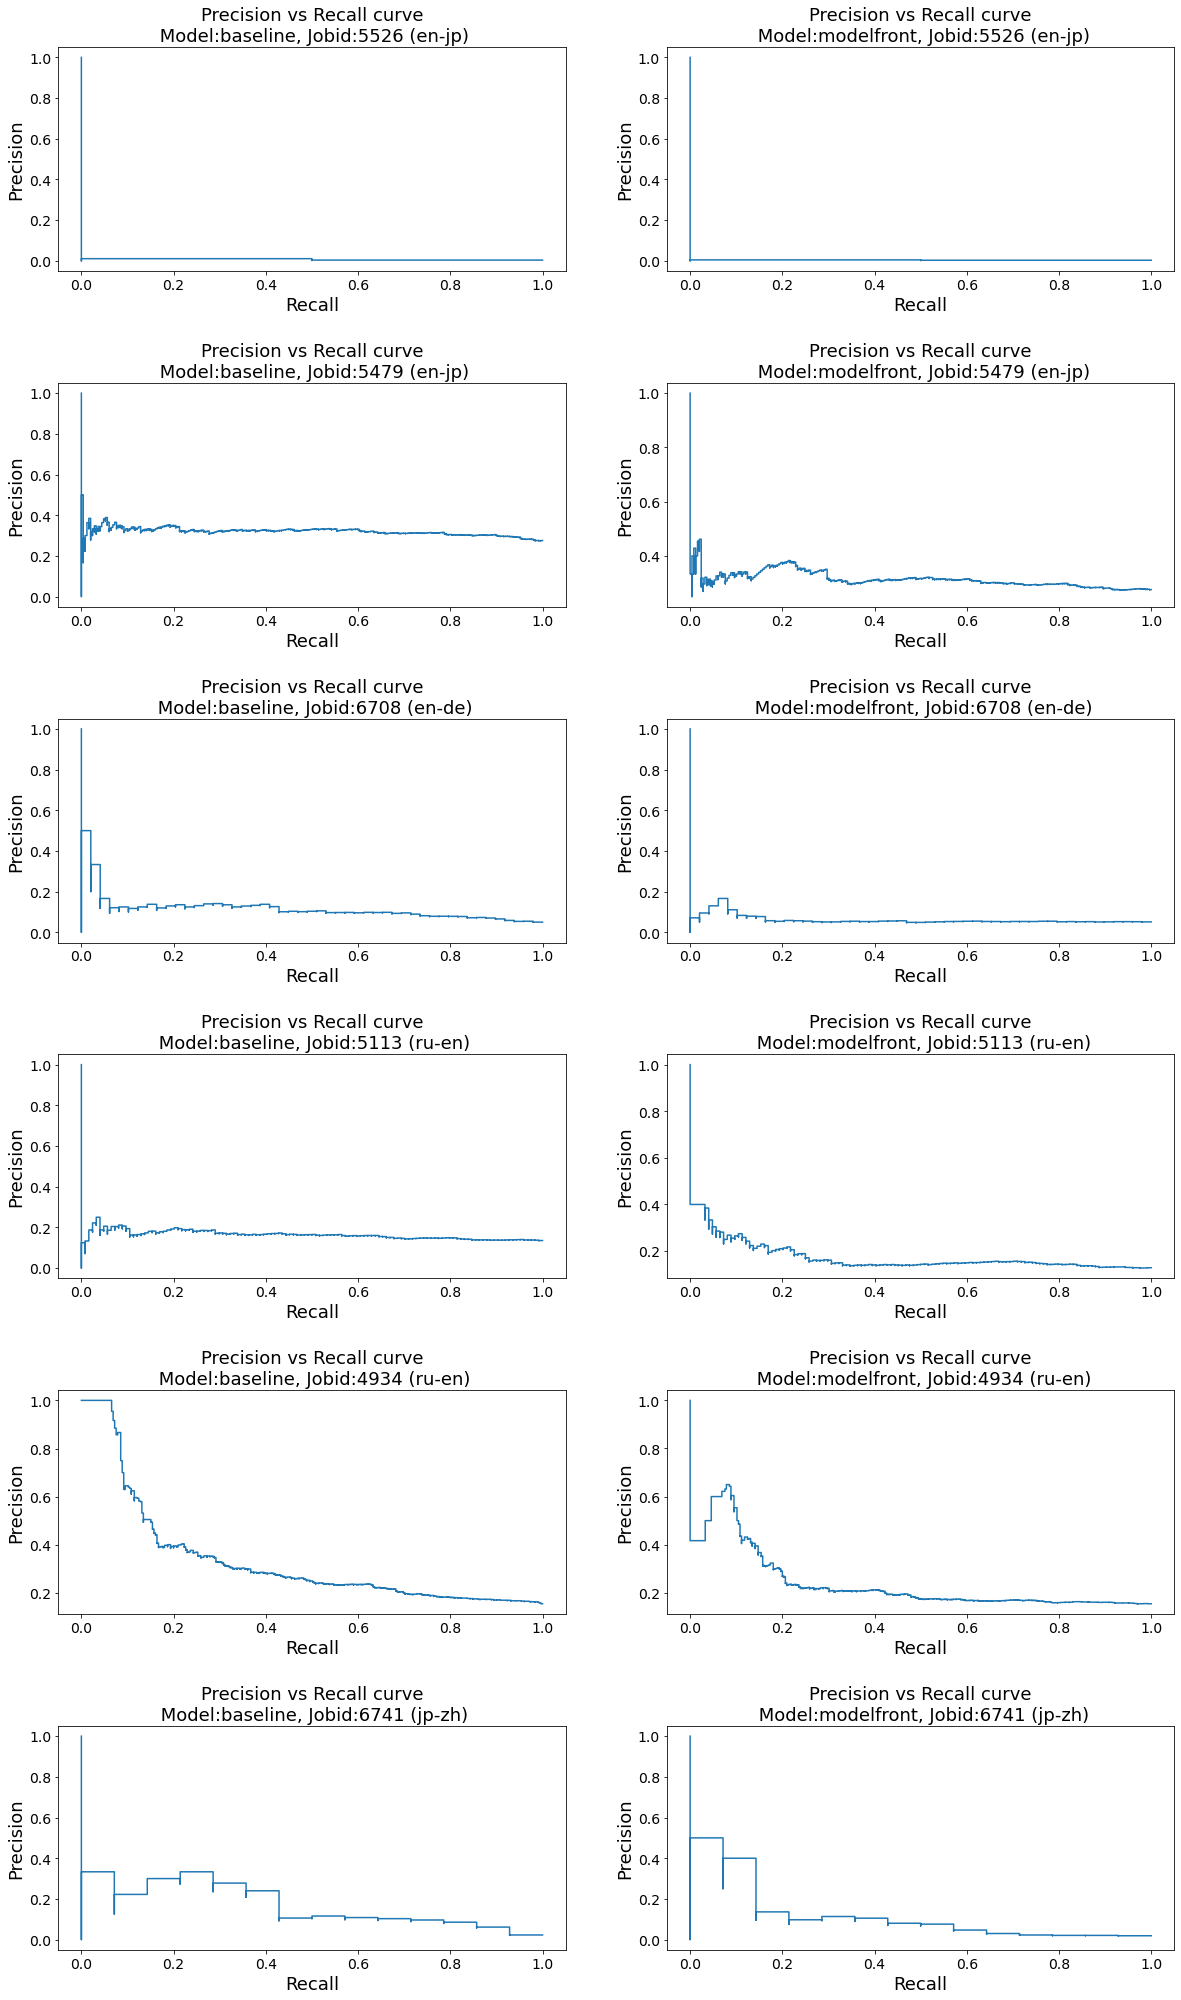

In [31]:
# Invert the labels and scores to put the 'rare' classe (accuracy=False) as positive
df["accuracy"] = df.accuracy.apply(lambda accuracy: not accuracy)
df["score"] = df.score.apply(lambda score: 1 - score)

# Plot the density distribution of scores
fig, axes = plt.subplots(
    ncols=len(df.model.unique()), nrows=len(df.jobid.unique()), figsize=(20, 35)
)
fig.subplots_adjust(hspace=0.5)

# plot each one of the density functions
for i, model in enumerate(df.model.unique()):
    for j, jobid in enumerate(df.jobid.unique()):
        # only one model hack
        # ax = axes[j]
        ax = axes[j][i]

        scores = df[(df.model == model) & (df.jobid == jobid)]["score"]
        y = np.array(
            [
                1 if label == True else 0
                for label in df[(df.model == model) & (df.jobid == jobid)]["accuracy"]
            ]
        )
        language_pair = df[(df.model == model) & (df.jobid == jobid)][
            "language_pair"
        ].values[0]

        precision, recall, thresholds = precision_recall_curve(y, scores, pos_label=1)
        PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax)

        ax.set_title(
            f"Precision vs Recall curve\n Model:{model}, Jobid:{jobid} ({language_pair})"
        )

# Revert the labels and scores back to the previous values
df["accuracy"] = df.accuracy.apply(lambda accuracy: not accuracy)
df["score"] = df.score.apply(lambda score: 1 - score)

---
**Analysis:**

* The Precision vs Recall curves show the expected behaviour for both models. The precision starts higher and downgrade as I decrease my probability threshold (left to rigth in the graph).
---

**Quality of each job batch**

Is there any correlation with the distributions and quality scores?

In [32]:
batch_accuracy = (
    df.groupby(["language_pair", "jobid"], as_index=False)
    .accuracy.mean()
    .rename(columns={"accuracy": "batch_accuracy"})
)
batch_accuracy

,language_pair,jobid,batch_accuracy
0,en-de,"6,708",0.95
1,en-jp,"5,479",0.73
2,en-jp,"5,526",1.00
3,jp-zh,"6,741",0.99
4,ru-en,"4,934",0.85
5,ru-en,"5,113",0.87


In [33]:
group_df = df.groupby(["language_pair", "jobid", "model"], as_index=False).score.agg(
    {"min": "min", "max": "max", "median": "median", "mean": "mean", "std": "std"}
)
group_df.merge(batch_accuracy, on=["language_pair", "jobid"]).sort_values(
    ["model", "language_pair", "batch_accuracy"]
)

,language_pair,jobid,model,min,max,median,mean,std,batch_accuracy
0,en-de,"6,708",baseline,0.27,1.00,0.89,0.85,0.12,0.95
2,en-jp,"5,479",baseline,0.18,0.96,0.80,0.77,0.13,0.73
4,en-jp,"5,526",baseline,0.18,0.96,0.80,0.77,0.12,1.00
6,jp-zh,"6,741",baseline,0.20,1.00,0.79,0.76,0.16,0.99
8,ru-en,"4,934",baseline,0.01,0.99,0.86,0.82,0.13,0.85
10,ru-en,"5,113",baseline,0.31,1.00,0.85,0.83,0.10,0.87
1,en-de,"6,708",modelfront,0.00,1.00,0.73,0.70,0.23,0.95
3,en-jp,"5,479",modelfront,0.00,1.00,0.99,0.91,0.22,0.73
5,en-jp,"5,526",modelfront,0.00,1.00,0.99,0.91,0.23,1.00
7,jp-zh,"6,741",modelfront,0.00,1.00,0.98,0.89,0.23,0.99


**Analysis:**

* We can not infer the quality of the batch directly from the mean/median/std from each model. The distribution of values is a characteristic of the probabilistic distribution of each model that has not been trained or standardized to match the accuracy of the batch. 
* We can not also compare directly the values between the 'baseline' and ModelFront as the models has a different approach to distribute the probabilities. ModelFront concentrate more items as 'good quality' but also has more errors on that class.
* One possible analysis is to compare the rank order for the batches for each language pair when compared with the mean of each model.
  * For example, for the language-pair 'en-jp', we have the this ranking order sorting by the accuracy of each batch accuracy: 5526 (100%) > 5479 (73%). When comparing the batches using the score for each model, we observe a equal mean for both 'baseline': 5526 (0.80) = 5479 (0.80), and for 'modelfront': 5526 (0.91) = 5479 (0.91).
  * For the language-pair 'ru-en', we have the this ranking order sorting by the accuracy of each batch accuracy: 5113 (87%) > 4934 (85%). When comparing the batches using the score for each model, we observe a similar rank for both 'baseline': 5113 (0.83) > 4934 (0.82), and for 'modelfront': 5113 (0.84) > 4934 (0.83).
* Because of the reduced size of the sample, and the highly unbalanced classes, it is not possible to take conclusions from these analyses.
* The mean, median, and standard deviation can not offer any direct inference over the batch accuracy value.
---

## The optimal threshold

To adapt our continous distribution to a discrete analysis (binary classification), it is necessary to provide a cut off point in the distribution to assign the exemples to each class. 

The ROC curve and Precision vs Recall charts showed that our distribution is sensitive to this threshold and a trade-off between precision and recall is necessary to take into account when deciding by this parameter.

To that goal, this section computes the best threshold score to identify bad translations. The optimal threshold maximizes the difference between the True Positive Rate and the False Positive Rate considering the 'bad translation' as our class of interest (positive class) .

In [34]:
# Invert the labels and scores to put the class of interest (accuracy=False) as the positive class
df["accuracy"] = df.accuracy.apply(lambda accuracy: not accuracy)
df["score"] = df.score.apply(lambda score: 1 - score)

for model in df.model.unique():
    print(f"Optimal thresholds for {model}")
    for language_pair in df.language_pair.unique():
        print(f"\t{language_pair}:")
        for jobid in df[df.language_pair == language_pair].jobid.unique():

            scores = df[
                (df.model == model)
                & (df.language_pair == language_pair)
                & (df.jobid == jobid)
            ]["score"]
            y = np.array(
                [
                    1 if label == True else 0
                    for label in df[
                        (df.model == model)
                        & (df.language_pair == language_pair)
                        & (df.jobid == jobid)
                    ]["accuracy"]
                ]
            )

            fpr, tpr, thresholds = roc_curve(y, scores, pos_label=1)
            
            # we want to find the threshold which maximize the True Positive Rate with less errors as possible (False Positive Rate).
            index = np.argmax(tpr - fpr)

            # as we inverted the distribution, the 'final' threshold should also be inverted
            threshold = 1 - thresholds[index]

            print(f"\t\tJob id {jobid}: {threshold:.2f}")
    print()

# Revert the labels and scores back to the previous values
df["accuracy"] = df.accuracy.apply(lambda accuracy: not accuracy)
df["score"] = df.score.apply(lambda score: 1 - score)

Optimal thresholds for baseline
	en-jp:
		Job id 5526: 0.62
		Job id 5479: 0.80
	en-de:
		Job id 6708: 0.85
	ru-en:
		Job id 5113: 0.86
		Job id 4934: 0.84
	jp-zh:
		Job id 6741: 0.59

Optimal thresholds for modelfront
	en-jp:
		Job id 5526: 0.96
		Job id 5479: 0.99
	en-de:
		Job id 6708: 0.84
	ru-en:
		Job id 5113: 0.99
		Job id 4934: 0.85
	jp-zh:
		Job id 6741: 0.74



---
**Analysis:**
* Due to the characteristics of each model, the thresholds for 'baseline' are lower than the ones for ModelFront.
* Within a batch, we observed very distinct thresholds.
  * For example, for 'en-jp', the jobid 5526 has the best threshold of '0.62' while the 5479 of '0.8'.
  * For 'ru-en', the jobid 5113 has the best threshold of '0.86' while the 4934 has '0.84'
  * This possibly represents some problems on the jobid 5526 as it outliers from the other ones. 
* Due to the specific distribution of each batch, it is difficult to precise the correct threshold that would work for any new batch. 
---

In this next block, let's compute one threshold per language pair, not per batch.

In [35]:
# keep the optimal threshold for each job
language_model_threshold = {}

# Invert the labels and scores to put the class of interest (accuracy=False) as the positive class
df["accuracy"] = df.accuracy.apply(lambda accuracy: not accuracy)
df["score"] = df.score.apply(lambda score: 1 - score)

for model in df.model.unique():
    if model not in language_model_threshold:
        language_model_threshold[model] = {}
    print(f"Optimal thresholds for {model}")
    for language_pair in df.language_pair.unique():

        scores = df[(df.model == model) & (df.language_pair == language_pair)]["score"]
        y = np.array(
            [
                1 if label == True else 0
                for label in df[
                    (df.model == model) & (df.language_pair == language_pair)
                ]["accuracy"]
            ]
        )

        fpr, tpr, thresholds = roc_curve(y, scores, pos_label=1)

        # we want to find the threshold which maximize the True Positive Rate with less errors as possible (False Positive Rate).
        index = np.argmax(tpr - fpr)

        # as we inverted the distribution, the 'final' threshold should also be inverted
        threshold = 1 - thresholds[index]
        language_model_threshold[model][language_pair] = threshold

        print(f"\tLanguage pair '{language_pair}': {threshold:.2f}")
    print()

# Revert the labels and scores back to the previous values
df["accuracy"] = df.accuracy.apply(lambda accuracy: not accuracy)
df["score"] = df.score.apply(lambda score: 1 - score)

Optimal thresholds for baseline
	Language pair 'en-jp': 0.84
	Language pair 'en-de': 0.85
	Language pair 'ru-en': 0.84
	Language pair 'jp-zh': 0.59

Optimal thresholds for modelfront
	Language pair 'en-jp': 0.99
	Language pair 'en-de': 0.84
	Language pair 'ru-en': 0.84
	Language pair 'jp-zh': 0.74



**Representing the distribution of translation pair and the optimal threshold**

In the following chart, we plot the histograms of the predicted quality scores categorized by the correct class.

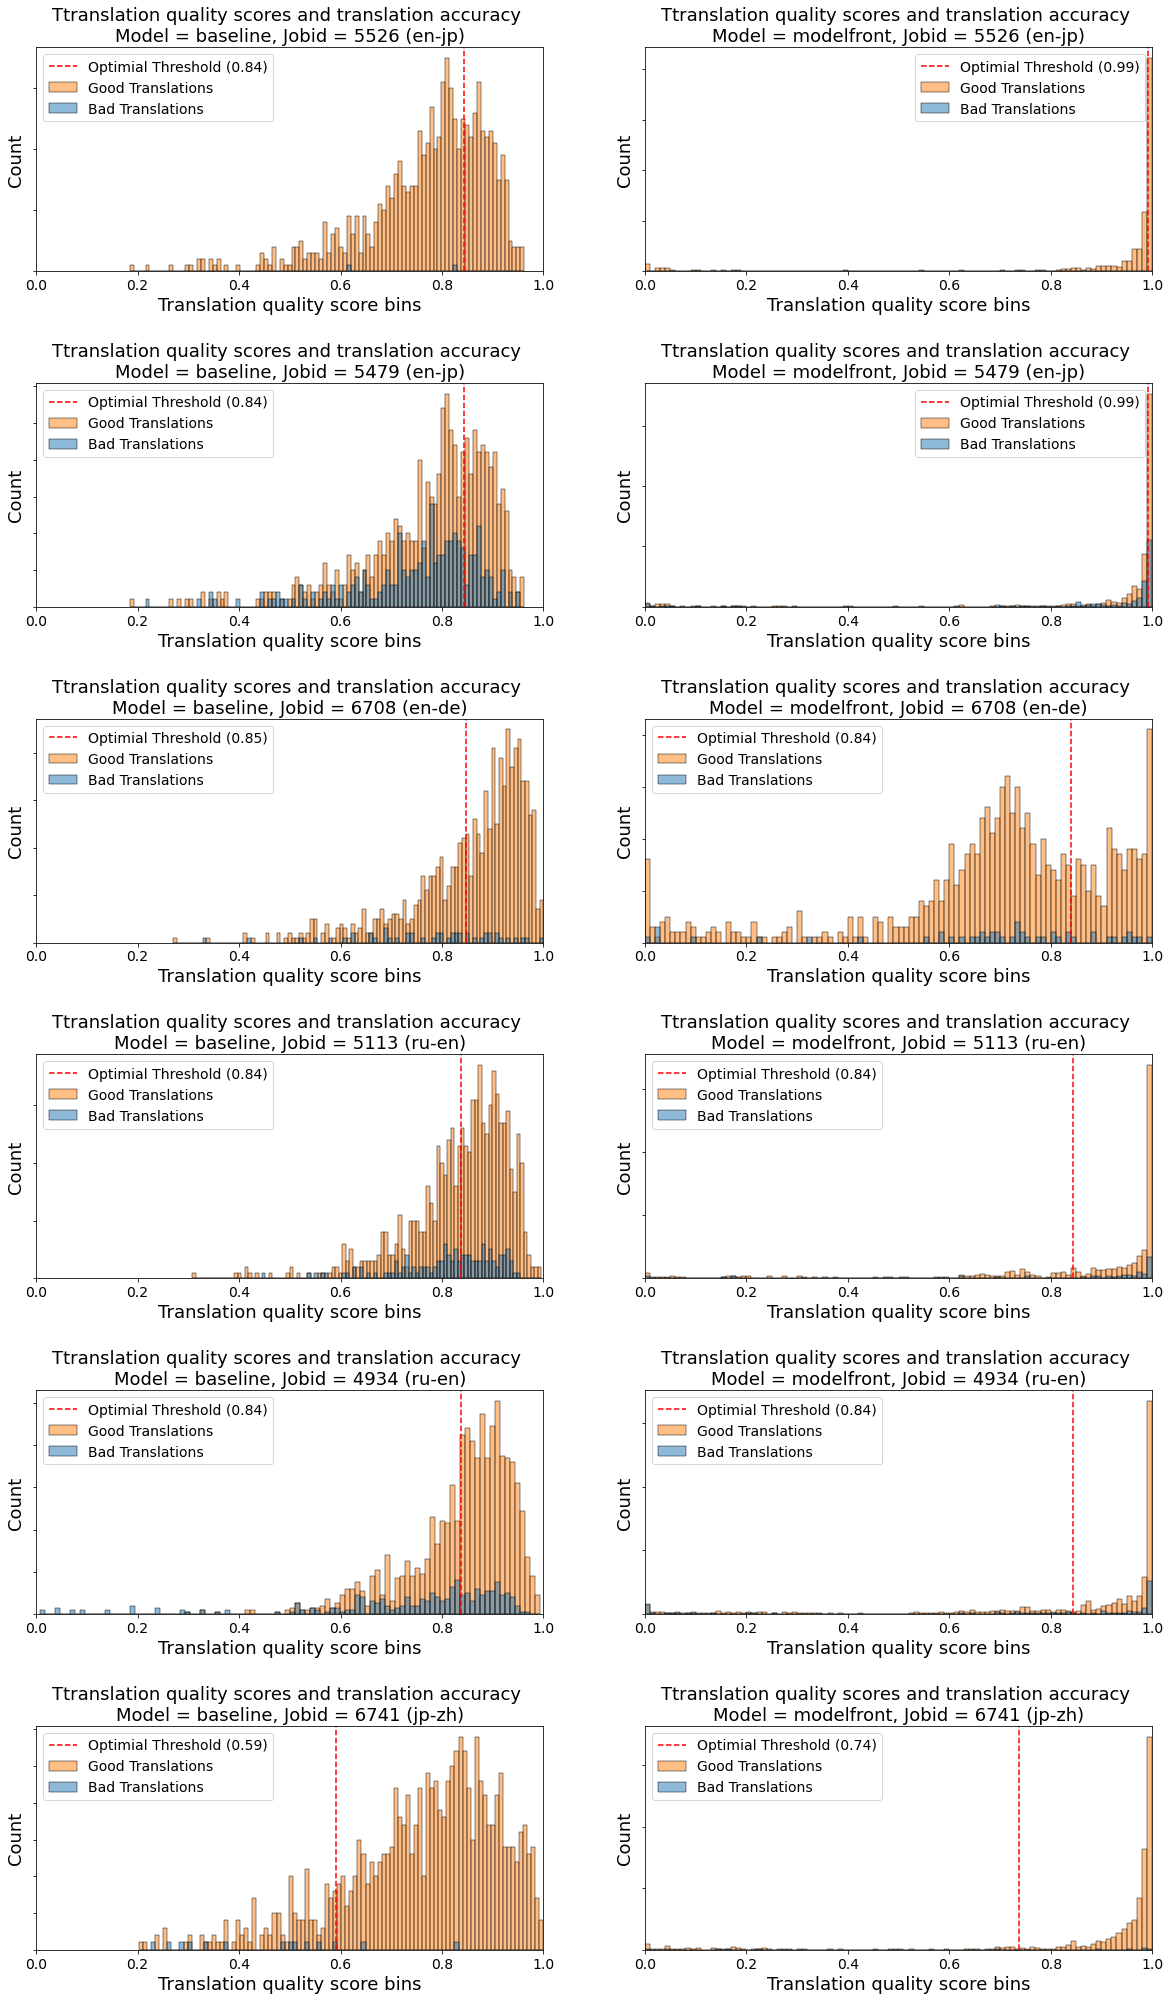

In [36]:
# Plot the density distribution of scores
fig, axes = plt.subplots(
    ncols=len(df.model.unique()), nrows=len(df.jobid.unique()), figsize=(20, 35)
)
fig.subplots_adjust(hspace=0.5)

# plot each one of the density functions
for i, model in enumerate(df.model.unique()):
    for j, jobid in enumerate(df.jobid.unique()):
        # only one model hack
        # ax = axes[j]
        ax = axes[j][i]

        slice_df = df[(df.model == model) & (df.jobid == jobid)]

        language_pair = df[(df.model == model) & (df.jobid == jobid)][
            "language_pair"
        ].values[0]

        sns.histplot(slice_df, x="score", hue="accuracy", bins=100, ax=ax)

        ax.set(
            xlabel="Translation quality score bins",
            ylabel="Count",
            title=f"Ttranslation quality scores and translation accuracy \nModel = {model}, Jobid = {jobid} ({language_pair})",
        )
        ax.axvline(
            language_model_threshold[model][language_pair],
            ls="--",
            color="r",
        )
        ax.legend(
            [
                f"Optimial Threshold ({language_model_threshold[model][language_pair]:.2f})",
                "Good Translations",
                "Bad Translations",
            ]
        )

        ax.set_xlim(0, 1)
        ax.set_yticklabels([])
        # Save just the portion _inside_ the second axis's boundaries
        # extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
        # fig.savefig(f"threshold_{model}_{jobid}.png", bbox_inches=extent)

---
**Analysis:**
   * We observed the 'bad translation' examples distributed across the [0,1] range for the predicted quality score.
   * Due to the skewed distribution of some batches, it is difficult to locate exactly where the few 'bad translation' examples occurred.
   * The next analysis will tell us more about the data and how to measure classification tasks using it.
---

## Binary Classification

Here we classify the sentence pairs that have a **accuracy** label in our data set (accuracy: **Is the meaning of the source conveyed?**) in a binary way (**true** or **false**). **True** if the score is above the **optimal threshold** and **False** otherwise.

In [37]:
def binary_classifier(value, threshold):
    if value > threshold:
        return True
    else:
        return False


df["prediction"] = df.apply(
    lambda row: binary_classifier(
        row["score"], language_model_threshold[row.model][row.language_pair]
    ),
    axis=1,
)

In [38]:
# let's check our dataframe with this new column
df.head()

,source,target,language_pair,jobid,agreement,accuracy,model,score,prediction
0,All lined up eat me in the warehouse,倉庫内ですべての準備が整いました,en-jp,"5,526",True,False,baseline,0.62,False
1,All lined up eat me in the warehouse,倉庫内ですべての準備が整いました,en-jp,"5,526",True,False,modelfront,0.96,False
2,I am at the airport at the moment I am picking somebody up in the next 10 minutes if I don't call you back I am driving back the customer to Epping,私は今空港です。あと10分で人を迎えるのでもし電話を私が返さなかったら、お客様をエッピングに車で送っているところです,en-jp,"5,526",True,False,baseline,0.83,False
3,I am at the airport at the moment I am picking somebody up in the next 10 minutes if I don't call you back I am driving back the customer to Epping,私は今空港です。あと10分で人を迎えるのでもし電話を私が返さなかったら、お客様をエッピングに車で送っているところです,en-jp,"5,526",True,False,modelfront,1.00,True
4,Don't eat anything from midnight and only have sips of water after 6 AM,真夜中は何も食べず、午前6時以降は水を少しだけ飲んでき,en-jp,"5,526",True,True,baseline,0.76,False


**Binary classification Evaluation - Our models x Benchmark**

Here, we evaluate our restuls using common metrics for classification such as Accuracy, Precision, Recall and F1 score.

**Confusion Matrix**

The confusion matrix shows us how the classification occurred in each class ('good' or 'bad' translations) and how many are:

- True Positives (TP) - correctly predicted in this class;
- True Negatives (TN) - correctly predicted outside this class;
- False Positives (FP) - incorrectly predicted in this class;
- False Negatives (FN) -  incorrectly predicted outside this class;

**Classification Report**

With the values above defined, for each one of the classification classes, we can mesure the following classification metrics:

* **#class** - TP + FP - the number of examples that belong to this class;
* **#correct** - TP - the number of examples correctly predicted in this class;
* **#incorrect** - FN - the number of examples predicted in this class, but that don't belong to it;
* **precision** - TP / (TP + FP) - the number of correcly classified in this class divided by the total number of elements labelled as belonging to the given class [[ref](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context))];
* **recall** - TP / (TP + FN) - the number of correcly classified in this class divided by the total number of elements that actually belong to this class [[ref](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context))];
* **f1** - 2*(precion+recall)/(precision+recall) - weighted average of the precision and recall.

In addition, for each classifier, disregarding the class, we can measure the overall accuracy:

* **accuracy** - the number of correctly classified over the number of all translation pairs, i.e, (TP+TN) / (TP+TN+FP+FN)

The following tabel summarized the metrics for all models and job batches.

In [40]:
def classification_metrics(row):
    metrics = classification_report(
        row["accuracy"], row["prediction"], output_dict=True
    )
    return pd.Series(
        [
            metrics["accuracy"],
            str(metrics["False"]["support"]),  # hack to force no decimal notation
            sum((row["prediction"] == False) & (row["accuracy"] == False)),
            sum((row["prediction"] == False) & (row["accuracy"] == True)),
            metrics["False"]["precision"],
            metrics["False"]["recall"],
            metrics["False"]["f1-score"],
            str(metrics["True"]["support"]),
            sum((row["prediction"] == True) & (row["accuracy"] == True)),
            sum((row["prediction"] == True) & (row["accuracy"] == False)),
            metrics["True"]["precision"],
            metrics["True"]["recall"],
            metrics["True"]["f1-score"],
        ],
        index=[
            [
                "accuracy",
                "Bad Translation",
                "Bad Translation",
                "Bad Translation",
                "Bad Translation",
                "Bad Translation",
                "Bad Translation",
                "Good Translation",
                "Good Translation",
                "Good Translation",
                "Good Translation",
                "Good Translation",
                "Good Translation",
            ],
            [
                "",
                "# class",
                "# correct",
                "# incorrect",
                "Precision",
                "Recall",
                "F1",
                "# class",
                "# correct",
                "# incorrect",
                "Precision",
                "Recall",
                "F1",
            ],
        ],
    )


df.groupby(["language_pair", "jobid", "model"], as_index=False).apply(
    classification_metrics
).sort_values(["language_pair", "jobid", "model"])

language_pair  jobid       model accuracy Bad Translation            \
                                                     # class # correct   
0          en-de  6,708    baseline     0.65              49        35   
1          en-de  6,708  modelfront     0.30              49        39   
2          en-jp  5,479    baseline     0.47             249       196   
3          en-jp  5,479  modelfront     0.53             249       151   
4          en-jp  5,526    baseline     0.32               2         2   
5          en-jp  5,526  modelfront     0.47               2         1   
6          jp-zh  6,741    baseline     0.87              14        12   
7          jp-zh  6,741  modelfront     0.90              14         8   
8          ru-en  4,934    baseline     0.63             305       192   
9          ru-en  4,934  modelfront     0.68             305       123   
10         ru-en  5,113    baseline     0.59             124        66   
11         ru-en  5,113  modelfront     0.67             124        41   

                                     Good Translation                        \
   # incorrect Precision Recall   F1          # class # correct # incorrect   
0          331      0.10   0.71 0.17              932       601          14   
1          672      0.05   0.80 0.10              932       260          10   
2          425      0.32   0.79 0.45              659       234          53   
3          327      0.32   0.61 0.42              659       332          98   
4          570      0.00   1.00 0.01              834       264           0   
5          439      0.00   0.50 0.00              834       395           1   
6          128      0.09   0.86 0.16              976       848           2   
7           97      0.08   0.57 0.13              976       879           6   
8          622      0.24   0.63 0.34             1683     1,061         113   
9          457      0.21   0.40 0.28             1683     1,226         182   
10         340      0.16   0.53 0.25              841       501          58   
11         237      0.15   0.33 0.20              841       604          83   

                          
   Precision Recall   F1  
0       0.98   0.64 0.78  
1       0.96   0.28 0.43  
2       0.82   0.36 0.49  
3       0.77   0.50 0.61  
4       1.00   0.32 0.48  
5       1.00   0.47 0.64  
6       1.00   0.87 0.93  
7       0.99   0.90 0.94  
8       0.90   0.63 0.74  
9       0.87   0.73 0.79  
10      0.90   0.60 0.72  
11      0.88   0.72 0.79

In [220]:
# Let'see the performance per language
df.groupby(["language_pair", "model"], as_index=False).apply(
    classification_metrics
).sort_values(["language_pair", "model"])

language_pair       model accuracy Bad Translation                        \
                                             # class # correct # incorrect   
0         en-de    baseline     0.65              49        35         331   
1         en-de  modelfront     0.30              49        39         672   
2         en-jp    baseline     0.40             251       198         995   
3         en-jp  modelfront     0.50             251       152         766   
4         jp-zh    baseline     0.87              14        12         128   
5         jp-zh  modelfront     0.90              14         8          97   
6         ru-en    baseline     0.62             429       258         962   
7         ru-en  modelfront     0.68             429       164         694   

                        Good Translation                                  \
  Precision Recall   F1          # class # correct # incorrect Precision   
0      0.10   0.71 0.17              932       601          14      0.98   
1      0.05   0.80 0.10              932       260          10      0.96   
2      0.17   0.79 0.27             1493       498          53      0.90   
3      0.17   0.61 0.26             1493       727          99      0.88   
4      0.09   0.86 0.16              976       848           2      1.00   
5      0.08   0.57 0.13              976       879           6      0.99   
6      0.21   0.60 0.31             2524     1,562         171      0.90   
7      0.19   0.38 0.25             2524     1,830         265      0.87   

               
  Recall   F1  
0   0.64 0.78  
1   0.28 0.43  
2   0.33 0.49  
3   0.49 0.63  
4   0.87 0.93  
5   0.90 0.94  
6   0.62 0.73  
7   0.73 0.79

---
**Analysis:**

* If we compare the metrics for the 'Bad Translation' (the class we used to optimize our threshold choice), with the exception of the 'en-de' pair, the 'baseline' has a higher recall score for this class (it gets more 'bad translations' - our optimization choice). For the 'en-de' language pair, ModelFront has a higher recall, but also the double of incorrect examples in this class (half of the precision).
* Overall, the 'baseline' model has better f1-score values for the 'bad translation' class when comparing the two models.
---

### Bussines Impact on the definition of each threshold

In the previous analysis, we observed that different translation batches can require different thresholds for a binary classification into 'good' and 'bad' translations.

In this section, we want to ilustrate and discuss what is the business impact of selecting different thesholds and how to guide future batches for this decision.

**What is the cost to select the optimal threshold we defined previously?**

By cost, we want to analyse specifically the **'bad translation'** identification and understand how many translation pairs are classified as such (**#total**), and, from those, how many were correcly classified (**#correct**) and what is the recall rate for this class (**recall**). 

In [41]:
def threshold_cost(row):

    threshold = language_model_threshold[row.model.values[0]][
        row.language_pair.values[0]
    ]
    threshold = round(threshold, 2)

    return pd.Series(
        [
            # bad translations - TP + FN
            str(sum(row.score <= threshold)),
            # correct - TP
            sum((row.score <= threshold) & (row.accuracy == False)),
            # % recall -  TP / TP + FN
            sum((row.score <= threshold) & (row.accuracy == False))
            / sum(row.accuracy == False),
        ],
        index=[
            [
                "Bad Translation",
                "Bad Translation",
                "Bad Translation",
            ],
            ["#total", "#correct", "recall"],
        ],
    )


df.groupby(["language_pair", "jobid", "model"], as_index=False).apply(
    threshold_cost
).sort_values(["language_pair", "jobid", "model"])

language_pair  jobid       model Bad Translation                
                                             #total #correct recall
0          en-de  6,708    baseline             371       35   0.71
1          en-de  6,708  modelfront             708       38   0.78
2          en-jp  5,479    baseline             610      190   0.76
3          en-jp  5,479  modelfront             449      141   0.57
4          en-jp  5,526    baseline             563        2   1.00
5          en-jp  5,526  modelfront             416        1   0.50
6          jp-zh  6,741    baseline             138       11   0.79
7          jp-zh  6,741  modelfront             106        8   0.57
8          ru-en  4,934    baseline             840      193   0.63
9          ru-en  4,934  modelfront             576      121   0.40
10         ru-en  5,113    baseline             418       68   0.55
11         ru-en  5,113  modelfront             273       40   0.32

---
**Analysis:**

* With the optimal threshold per language, the results are the same as we got in the previous section.
* We observe that the 'baseline' model is better compared with ModelFront on identifing 'bad translations'.
---

**What would be the cost if I use other thresholds?**

In the following table, we continue our analysis on the **"bad translation"** identification and show how different threshold could change the metrics we are evaluating.

In [42]:
def threshold_cost(row):

    best_threshold = language_model_threshold[row.model.values[0]][
        row.language_pair.values[0]
    ]

    series = []
    header = []
    columns = []
    # header.append(best_threshold)
    for threshold in np.arange(0, 1, 0.1):
        threshold = round(threshold, 2)
        # bad translations - TP + FN
        series.append(str(sum(row.score <= threshold)))
        # correct - TP
        series.append(sum((row.score <= threshold) & (row.accuracy == False)))
        # % recall -  TP / TP + FN
        series.append(
            sum((row.score <= threshold) & (row.accuracy == False))
            / sum(row.accuracy == False)
        )
        header += ["threshold = {}".format(threshold)] * 3
        columns += ["#total", "#correct", "recall"]
    return pd.Series(series, index=[header, columns])


df.groupby(["language_pair", "jobid", "model"], as_index=False).apply(
    threshold_cost
).sort_values(["language_pair", "jobid", "model"])

language_pair  jobid       model threshold = 0.0                  \
                                             #total #correct recall   
0          en-de  6,708    baseline               0        0   0.00   
1          en-de  6,708  modelfront               0        0   0.00   
2          en-jp  5,479    baseline               0        0   0.00   
3          en-jp  5,479  modelfront               3        1   0.00   
4          en-jp  5,526    baseline               0        0   0.00   
5          en-jp  5,526  modelfront               3        0   0.00   
6          jp-zh  6,741    baseline               0        0   0.00   
7          jp-zh  6,741  modelfront               1        0   0.00   
8          ru-en  4,934    baseline               0        0   0.00   
9          ru-en  4,934  modelfront              24       10   0.03   
10         ru-en  5,113    baseline               0        0   0.00   
11         ru-en  5,113  modelfront              10        4   0.03   

   threshold = 0.1                 threshold = 0.2                  \
            #total #correct recall          #total #correct recall   
0                0        0   0.00               0        0   0.00   
1               47        5   0.10              65        5   0.10   
2                0        0   0.00               1        0   0.00   
3               34       10   0.04              48       15   0.06   
4                0        0   0.00               1        0   0.00   
5               37        0   0.00              53        0   0.00   
6                0        0   0.00               0        0   0.00   
7               34        3   0.21              53        5   0.36   
8                9        9   0.03              15       15   0.05   
9              116       45   0.15             158       49   0.16   
10               0        0   0.00               0        0   0.00   
11              34        9   0.07              56       14   0.11   

   threshold = 0.3                 threshold = 0.4                  \
            #total #correct recall          #total #correct recall   
0                1        0   0.00               3        1   0.02   
1               80        6   0.12              96        7   0.14   
2                5        1   0.00              19        6   0.02   
3               54       18   0.07              55       18   0.07   
4                4        0   0.00              16        0   0.00   
5               57        0   0.00              59        0   0.00   
6               11        3   0.21              32        6   0.43   
7               66        6   0.43              71        6   0.43   
8               22       21   0.07              30       26   0.09   
9              210       61   0.20             232       62   0.20   
10               0        0   0.00               3        0   0.00   
11              76       17   0.14              90       20   0.16   

   threshold = 0.5                 threshold = 0.6                  \
            #total #correct recall          #total #correct recall   
0               14        2   0.04              44        5   0.10   
1              126        8   0.16             200       11   0.22   
2               37       14   0.06              91       30   0.12   
3               57       19   0.08              59       19   0.08   
4               31        0   0.00              83        0   0.00   
5               60        0   0.00              62        0   0.00   
6               72        8   0.57             151       12   0.86   
7               74        6   0.43              79        6   0.43   
8               38       27   0.09              99       47   0.15   
9              236       63   0.21             262       63   0.21   
10              10        1   0.01              26        5   0.04   
11             101       21   0.17             114       23   0.19   

   threshold = 0.7                 threshold = 0.8               

---
**Analysis:**

* Depending on the objective for the quality estimation, we may decide by choosing a different threshold cut.
* For example, if our goal is to get as many 'bad translations' as possible, we should target a higher threshold, with the penalty to have more False Positive examples (translation pairs misclassified as not accurate when they are are accurate.)
* On other example, if we want to get the top 'bad translations' only, we should target a lower threshold, as the 'concentration' of 'bad translations' will be higher.
---